# Import Packages for REINFORCE

In [1]:
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from tqdm import tqdm
import matplotlib.pyplot as plt

# We'll use OmegaConf to manage hyperparameters!

In [2]:
#!pip install omegaconf

In [3]:
from omegaconf import OmegaConf

# Environment
- LunarLander-v2
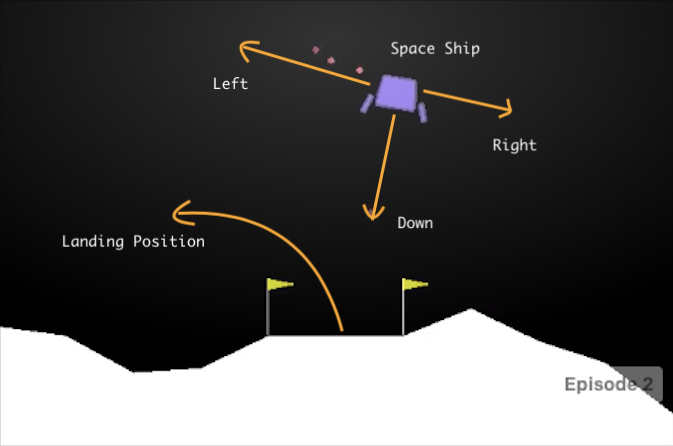

In [4]:
env = gym.make('LunarLander-v2')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>

# Hyperparameters
- Now they are in dictionary

In [5]:
config = OmegaConf.create({
    # DQN parameters
    'gamma': 0.999,
    
    # policy network parameters
    'device': 'cpu',
    'hidden_dim': 32,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.n),

    # learning parameters
    'learning_rate': 0.002,
})

# you can access in both ways:
config.gamma == config['gamma']

True

# Agent Class

In [6]:
class REINFORCE_Agent(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.data = []
        self.config = config
        
        self.policy_network = ...
        
        # load network to gpu (if available)
        self.to(self.config.device)
        
        # optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.config.learning_rate)
        
    def forward(self, state):
        return self.policy_network(state)
    
    # save data
    def put_data(self, item):
        self.data.append(item)
        
    # train network
    def train_net(self):
        R = 0
        self.optimizer.zero_grad()
        
        # compute return & backward
        ...
        
        self.optimizer.step()
        
        # clear data
        self.data = []

# Run

In [7]:
num_epis, epi_rews = 5000, []
agent = REINFORCE_Agent(config)

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0
    
    while not (terminated or truncated):
        # get action prob from agent & sample -- use Categorical!
        ...
        
        # step & get results
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        
        # save r & p(a|s)
        ...
        
        # transition
        state = next_state
        
        # record
        epi_rew += reward
        
    # train
    agent.train_net()
    
    # record
    epi_rews += [epi_rew]
    
env.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [07:44<00:00, 10.77it/s]


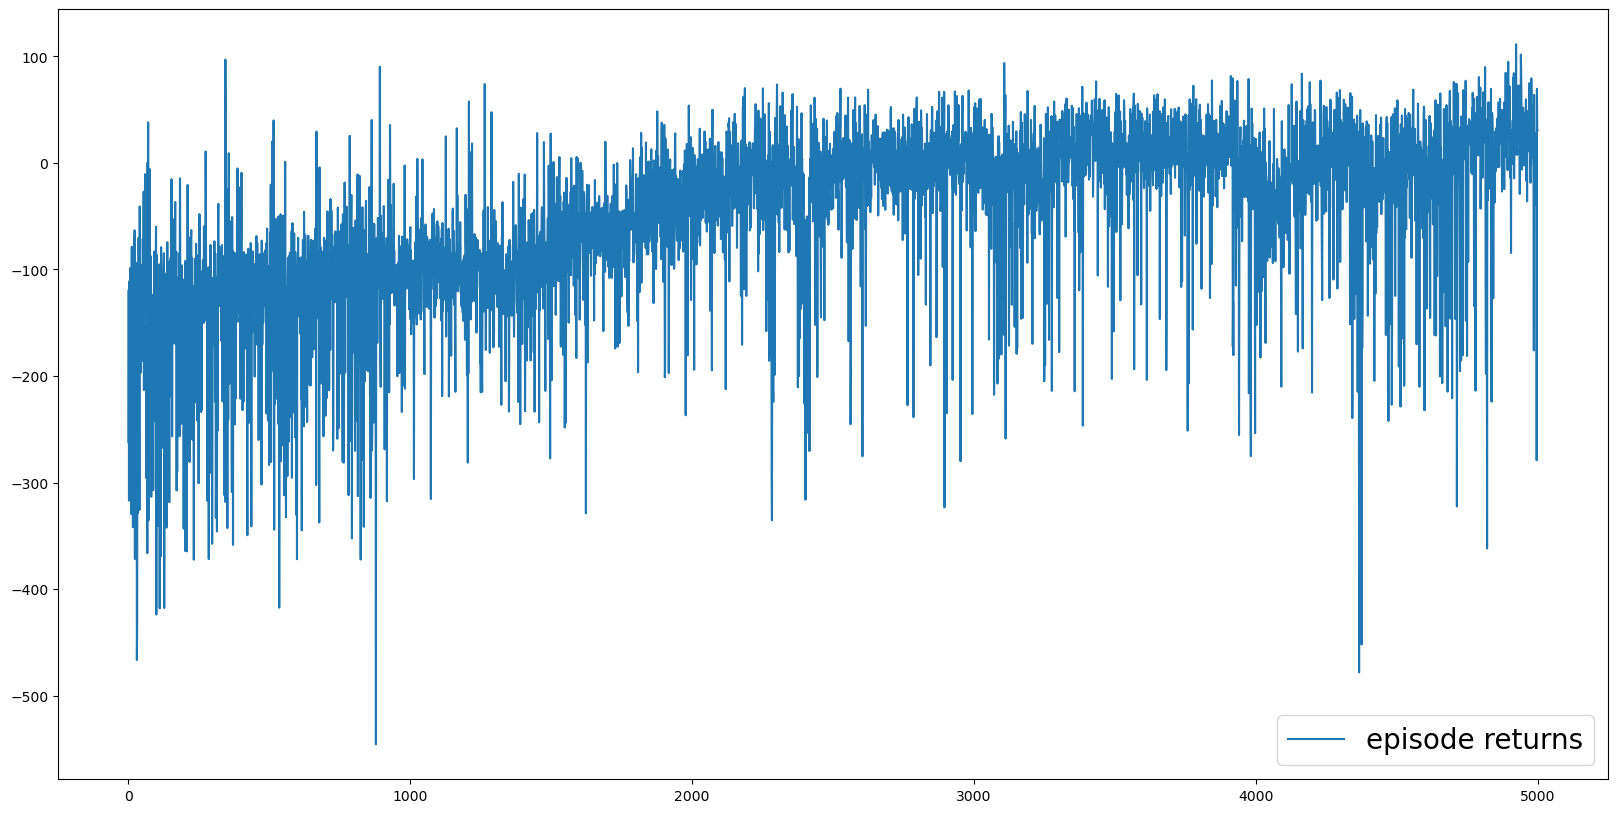

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(epi_rews, label='episode returns')
plt.legend(fontsize=20)
plt.show()
plt.close()